## **Case study 1: Comparison between precooling processes for hydrogen liquefaction**
<p style='text-align: justify;'>Hydrogen is emerging as a key clean energy carrier, potentially meeting up to 20% of global energy demand by 2050. However, its low volumetric density makes storage and transport difficult, making hydrogen liquefaction as a promising solution. The main barrier is its high energy consumption, with the precooling stage being the second most energy-intensive step. This stage spans the widest temperature range but allows flexibility in refrigerant selection, cycle design, and operating conditions.</p>

<p style='text-align: justify;'>Most studies on hydrogen liquefaction precooling system omits economic analysis. Ranggonang et al. [1] addressed this by conducting a multi-objective optimization study to minimize <b>specific energy consumption</b> and <b>levelized cost</b> in mixed-refrigerant systems. They developed two cycles—the single mixed refrigerant (SMR) and dual mixed refrigerant (DMR). In this case study, we adopt their system configurations from the worst and best optimization results to perform techno-economic analysis using this package, comparing the efficiency of each system, as well as the economic outcomes under uncertainty (using Monte Carlo).</p>

<p style='text-align: justify;'>The following figure presents the SMR process flow diagram, and the table summarizes the equipment sizing for the best and worst optimization outcomes:</p>

![case_study_1-figure_1](img/CS_1-Fig_1.png)
**<p style='text-align: justify;'>Figure 1.** Precooling stage of hydrogen liquefaction using a Single Mixed Refrigerant (SMR) cycle. Hydrogen enters at 298 K and 21 bar and is cooled to 80 K at constant pressure. The mixed refrigerant, circulated through compressors (COMP-1, COMP-2), intercoolers (INT-1, INT-2), and flash separators (FS-1, FS-2), provides staged cooling across plate-fin heat exchangers (PFHX-1 to PFHX-3). Electricity drives compression, while cooling water removes heat from intercoolers. A leakage rate of 1.5 kg/h is considered. The system capacity is 125 tonnes per day of hydrogen feed.</p>

**<center>Table 1.** Process equipment sizing for SMR configurations in the best and worst cases.
<span style="font-size: 14px">

| **Equipment**         | **Best Case**   | **Worst Case**   | **Equipment**         | **Best Case**   | **Worst Case**  |
|-----------------------|-----------------|------------------|-----------------------|-----------------|-----------------|
| **Plate Fin HX**      | **Volume (m³)** | **Volume (m³)**  | **Shell & Tube HX**   | **Area (m²)**   | **Area (m²)**   |
| PFHX-1                | 0.90            | 2.83             | INT-1                 | 185.49          | 170.63          |
| PFHX-2                | 1.27            | 1.90             | INT-2                 | 437.37          | 407.88          |
| PFHX-3                | 0.87            | 1.75             | **Total cooling duty**| 39690 MJ/h      | 47000 MJ/h      |
| **Compressor**        | **Power (kW)**  | **Power (kW)**   | **Flash Separator**   | **Weight (kg)** | **Weight (kg)** |
| COMP-1                | 4529.53         | 2950.72          | FS-1                  | 2874.88         | 3100.65         |
| COMP-2                | 4013.56         | 3561.59          | FS-2                  | 3969.61         | 2989.35         |

</span></center>

## **Techno-economic assessment**
Let us begin by performing the economic calculation for the SMR cycle, starting with the best-case scenario, using **OpenPyTEA**
#### **Step #1. Import the OpenPyTEA**

In [1]:
from openpytea.equipment import *
from openpytea.plant import *
from openpytea.analysis import *

#### **Step #2. Create the `Equipment` objects**

In [2]:
# Let's first make the objects for the heat exchangers. From Table 1 we can get the values for estimating the costs.
# For the plate- heat exchangers the cost correlations used here are based on the core volume (m3) of the heat exchangers.
pfhx_1 = Equipment(name ='PFHX-1', param=2.83,  # m^3
                   process_type='Fluids', 
                   category='Heat exchangers', type='Plate & fin 4-to-6-streams',
                   material='Aluminum')
pfhx_2 = Equipment(name='PFHX-2', param=1.90, process_type='Fluids', category='Heat exchangers', type='Plate & fin 4-to-6-streams', material='Aluminum')
pfhx_3 = Equipment(name='PFHX-3', param=1.75, process_type='Fluids', category='Heat exchangers', type='Plate & fin 3-streams', material='Aluminum')

# Now for the compressor intercoolers, we chose shell and tube heat exchangers, for which the cost correlations are based on the heat transfer area (m2).
int_1 = Equipment('INT-1', 170.63, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')
int_2 = Equipment('INT-2', 407.88, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')

# Now, we create the compressor and electric-motor (for driving the compressors) objects.
# We choose here the centrifugal type for both compressors.
comp_1_pwr = 2950.72 # kW
comp_2_pwr = 3561.59 # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")

# When the electric motor drives the compressors there are some losses involved. Here we assumed 90% efficiency.
mtr_eff = 0.9
mtr_1_pwr, mtr_2_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

# Now we create the flash separator objects. The cost correlations are based on the vessel empty mass (kg).
fs_1 = Equipment('FS-1', 3100.65, 'Fluids', 'Pressure vessels', 'Vertical CS', 'Carbon steel')
fs_2 = Equipment('FS-2', 2989.35, 'Fluids', 'Pressure vessels', 'Vertical CS', 'Carbon steel')

# We can now create a list of the equipment for the SMR process.
SMR_best_equipment = [
    pfhx_1, pfhx_2, pfhx_3, 
    comp_1, mtr_1, comp_2, mtr_2,
    int_1, int_2, fs_1, fs_2
]


#### **Step #3. Prepare the process plant configuration and create the `ProcessPlant` object**

In [3]:
# Configuration for the SMR best case
config = {'plant_name': 'SMR best',
          'process_type': 'Fluids', # Since no solids are involved, we choose 'Fluids'
          'country': 'Netherlands', 'region': None, # Here we take Netherlands as an example
          'equipment': SMR_best_equipment, # This the list of equipment for the SMR process
          'interest_rate': 0.09, 'project_lifetime': 20, 'plant_utilization': 0.95, # Base economic assumptions
          'operator_hourly_rate': {
              'rate': 38.11, 'std': 10, 'max': 50, 'min': 20
              },
          'plant_products': {  # Here we define the products and/or inputs of the plant
              'liquid_h2': {
                  'production': 125_000, # Daily production in kg/day,
              }
            },
          'variable_opex_inputs': { # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (mtr_1_pwr + mtr_2_pwr)*24, 'price': 0.10, 'std': 0.05/2, 'max': 3, 'min': 0.01
              },
              'refrigerant': { # 1.5 kg/h is taken from Figure 1
                  'consumption': 1.5*24, 'price': 5, 'std': 3/2, 'max': 10, 'min': 1
              },
              'cooling_water':{ # 11.03 kg/h is taken from Figure 1
                  'consumption': 39690*24, 'price': 2.4592e-4, 'std': 1e-4, 'max': 4e-4, 'min': 1e-5
              }
            },
}
SMR_best = Plant(config)  # Create the process plant object. Here we name it SMR_best.

#### **Step #4. Calculate the economic parameters of the process plant**

In [4]:
# You can perform any of the following calculations on the SMR_best object. Here we would like only to compare between processes, for this we just need the levelized cost.

# SMR_best.calculate_fixed_capital(print_results=True)
# SMR_best.calculate_variable_opex(print_results=True)
# SMR_best.calculate_fixed_opex(print_results=True)
# SMR_best.calculate_cash_flow(print_results=True)
SMR_best.calculate_levelized_cost(print_results=True)

# With the information given, we can also calculate the specific energy consumption, which is defined as the total energy consumption in kWh divided by the total production in kg
SEC_SMR_best = (mtr_1_pwr + mtr_2_pwr)*24 / SMR_best.daily_prod
print(f'Specific energy consumption: {SEC_SMR_best:.3f} kWh/kg')

Levelized cost: $0.696/unit
Specific energy consumption: 1.389 kWh/kg


#### **Step #5. Repeat the steps for SMR worst case**

In [5]:
# Plate-fin heat exchangers
pfhx_1 = Equipment('PFHX-1', 0.90, 'Fluids', 'Heat Exchangers', 'Plate & fin 4-to-6-streams', 'Aluminum')
pfhx_2 = Equipment('PFHX-2', 1.27, 'Fluids', 'Heat Exchangers', 'Plate & fin 4-to-6-streams', 'Aluminum')
pfhx_3 = Equipment('PFHX-3', 0.87, 'Fluids', 'Heat Exchangers', 'Plate & fin 3-streams', 'Aluminum')

# Intercoolers (shell and tube heat exchangers)
int_1 = Equipment('INT-1', 185.49, "Fluids", "Heat Exchangers", "U-tube shell & tube",'Carbon steel')
int_2 = Equipment('INT-2', 437.37, "Fluids", "Heat Exchangers", "U-tube shell & tube",'Carbon steel')

# Compressors and electric motors
comp_1_pwr = 4529.53  # kW
comp_2_pwr = 4013.56  # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
mtr_1_pwr, mtr_2_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

# Flash separators
fs_1 = Equipment('FS-1', 2874.88, 'Fluids', 'Pressure vessels', 'Vertical CS', 'Carbon steel')
fs_2 = Equipment('FS-2', 3969.61, 'Fluids', 'Pressure vessels', 'Vertical CS', 'Carbon steel')

# List of equipment for SMR worst scenario
SMR_worst_equipment = [
    pfhx_1, pfhx_2, pfhx_3,
    comp_1, mtr_1, comp_2, mtr_2,
    int_1, int_2, fs_1, fs_2
]

In [6]:
# Since the configuration for the worst case is similar to the best case, we can reuse it.
# Here we create a deep copy of the best case configuration.
from copy import deepcopy
SMR_worst = deepcopy(SMR_best)

# Update the configuration for the worst case scenario
config = {
    'plant_name': 'SMR worst', 'equipment': SMR_worst_equipment,
    'variable_opex_inputs': {
        'electricity': {
            'consumption': (mtr_1_pwr + mtr_2_pwr)*24
        },
        'cooling_water':{
            'consumption': 47000*24
        }
    }
}

SMR_worst.update_configuration(config)

In [7]:
# Performing the levelized cost calculation
SMR_worst.calculate_levelized_cost(print_results=True)
# Calculating specific energy consumption
SEC_SMR_worst = (mtr_1_pwr + mtr_2_pwr)*24 / SMR_worst.daily_prod
print(f'Specific energy consumption: {SEC_SMR_worst:.3f} kWh/kg')

Levelized cost: $0.789/unit
Specific energy consumption: 1.823 kWh/kg


#### **Step #6. Repeat the steps for DMR best and worst cases**

The following figure presents the DMR process flow diagram, and the table summarizes the equipment sizing for the best and worst optimization results:

![case_study_1-figure_2](img/CS_1-Fig_2.png)
**<p style='text-align: justify;'>Figure 2.** Precooling stage of hydrogen liquefaction using a Dual Mixed Refrigerant (DMR) cycle. Hydrogen enters at 298 K and 21 bar and is cooled to 80 K at constant pressure, with a plant capacity of 125 tonnes per day. Two separate mixed refrigerant streams are employed: MR-1 provides initial cooling, while MR-2 delivers deeper precooling. Each stream undergoes staged compression, intercooling, and phase separation to enhance thermal efficiency. MR-1 is compressed via COMP-3 and COMP-4 with intercoolers (INT-3, INT-4) and supported by flash separator (FS-1) and a pump. MR-2 follows a separate compression path through COMP-1 and COMP-2 with intercoolers (INT-1, INT-2). The two refrigerant streams exchange heat with hydrogen across plate-fin heat exchangers (PFHX-1 to PFHX-3), supported by flash separator FS-2. Electricity drives compression, while cooling water removes heat from intercoolers. A refrigerant leakage rate of 3.0 kg/h is considered.</p>

**<center>Table 2.** Process equipment sizing for DMR configurations in the best and worst cases.
<span style="font-size: 14px">

| **Equipment**         | **Best Case**     | **Worst Case**    | **Equipment**         | **Best Case**     | **Worst Case**    |
|-----------------------|-------------------|-------------------|-----------------------|-------------------|-------------------|
| **Plate Fin HX**      | **Volume (m³)**   | **Volume (m³)**   | **Shell & Tube HX**   | **Area (m²)**     | **Area (m²)**     |
| PFHX-1                | 6.27              | 2.62              | INT-1                 | 123.89            | 129.44            |
| PFHX-2                | 1.87              | 2.03              | INT-2                 | 144.65            | 149.05            |
| PFHX-3                | 0.70              | 0.45              | INT-3                 | 597.75            | 150.02            |
| **Compressor**        | **Power (kW)**    | **Power (kW)**    | INT-4                 | 411.52            | 689.22            |
| COMP-1                | 2205.75           | 2240.08           | **Total cooling duty**| 37750 kJ/h        | 40520 MJ/h        |
| COMP-2                | 1334.72           | 1551.90           | **Flash Separator**   | **Weight (kg)**   | **Weight (kg)**   |
| COMP-3                | 1874.70           | 1710.11           | FS-1                  | 3293.44           | -                 |
| COMP-4                | 481.63            | 1277.63           | FS-2                  | 2320.89           | 2067.60           |
| **Pump**              | **Power (kW)**    | **Power (kW)**    |                       |                   |                   |
| PUMP-1                | 8.55              | -                 |                       |                   |                   |

</span></center>

Proceeding to the best-case scenario for the DMR:

In [8]:
# Plate-fin heat exchangers
pfhx_1 = Equipment('PFHX-1', 6.27, 'Fluids', 'Heat Exchangers', 'Plate & fin 4-to-6-streams', 'Aluminum')
pfhx_2 = Equipment('PFHX-2', 1.87, 'Fluids', 'Heat Exchangers', 'Plate & fin 4-to-6-streams', 'Aluminum')
pfhx_3 = Equipment('PFHX-3', 0.70, 'Fluids', 'Heat Exchangers', 'Plate & fin 3-streams', 'Aluminum')

# Intercoolers (shell and tube heat exchangers)
int_1 = Equipment('INT-1', 597.75, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')
int_2 = Equipment('INT-2', 411.52, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')
int_3 = Equipment('INT-3', 123.89, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')
int_4 = Equipment('INT-4', 144.65, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')

# Compressors and electric motors
comp_1_pwr, comp_2_pwr, comp_3_pwr, comp_4_pwr = 2205.75, 1334.72, 1874.70, 481.63  # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_3 = Equipment('COMP-3', comp_3_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_4 = Equipment('COMP-4', comp_4_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")

mtr_1_pwr, mtr_2_pwr, mtr_3_pwr, mtr_4_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff, comp_3_pwr / mtr_eff, comp_4_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_3 = Equipment('MTR-3', mtr_3_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_4 = Equipment('MTR-4', mtr_4_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

# Pump
pump_1_pwr = 8.55  # kW
pump_1 = Equipment('PUMP-1', pump_1_pwr, 'Fluids', 'Pumps', 'Centrifugal', 'Carbon steel')

total_electricity = mtr_1_pwr + mtr_2_pwr + mtr_3_pwr + mtr_4_pwr + pump_1_pwr

# Flash separators
fs_1 = Equipment('FS-1', 3293.44, 'Fluids', 'Pressure vessels', 'Vertical CS', 'Carbon steel')
fs_2 = Equipment('FS-2', 2320.89, 'Fluids', 'Pressure vessels', 'Vertical CS', 'Carbon steel')

# List of equipment
DMR_best_equipment = [comp_1, comp_2, comp_3, comp_4, 
                      mtr_1, mtr_2, mtr_3, mtr_4,
                      int_1, int_2, int_3, int_4,
                      pfhx_1, pfhx_2, pfhx_3,   
                      fs_1, fs_2, 
                      pump_1]

# Configuration for the DMR best case (copying from SMR best case)
DMR_best = deepcopy(SMR_best)
# Updating config for DMR
config = {
    'plant_name': 'DMR best', 'equipment': DMR_best_equipment,
    'variable_opex_inputs': {
        'electricity': {
            'consumption': total_electricity*24
        },
        'refrigerant': { 
                  'consumption': 3*24
              },
        'cooling_water':{
            'consumption': 37750*24
        }
    }
}
DMR_best.update_configuration(config)

# Calculate the levelized cost
DMR_best.calculate_levelized_cost(print_results=True)
# Calculate the specific energy consumption
SEC_DMR_best = total_electricity / (DMR_best.daily_prod/24)
print(f'Specific energy consumption: {SEC_DMR_best:.3f} kWh/kg')

Levelized cost: $0.822/unit
Specific energy consumption: 1.260 kWh/kg


Proceeding to the worst-case scenario for the DMR:

In [9]:
# Plate-fin heat exchangers
pfhx_1 = Equipment('PFHX-1', 2.62, 'Fluids', 'Heat Exchangers', 'Plate & fin 4-to-6-streams', 'Aluminum')
pfhx_2 = Equipment('PFHX-2', 2.03, 'Fluids', 'Heat Exchangers', 'Plate & fin 4-to-6-streams', 'Aluminum')
pfhx_3 = Equipment('PFHX-3', 0.45, 'Fluids', 'Heat Exchangers', 'Plate & fin 3-streams', 'Aluminum')

# Intercoolers (shell and tube heat exchangers)
int_1 = Equipment('INT-1', 150.02, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')
int_2 = Equipment('INT-2', 689.22, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')
int_3 = Equipment('INT-3', 129.44, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')
int_4 = Equipment('INT-4', 149.05, 'Fluids', 'Heat exchangers', 'U-tube shell & tube', 'Carbon steel')

# Compressors and electric motors
comp_1_pwr, comp_2_pwr, comp_3_pwr, comp_4_pwr = 2240.08, 1551.90, 1710.11, 1277.63  # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_3 = Equipment('COMP-3', comp_3_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_4 = Equipment('COMP-4', comp_4_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")

mtr_1_pwr, mtr_2_pwr, mtr_3_pwr, mtr_4_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff, comp_3_pwr / mtr_eff, comp_4_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_3 = Equipment('MTR-3', mtr_3_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_4 = Equipment('MTR-4', mtr_4_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

total_electricity = mtr_1_pwr + mtr_2_pwr + mtr_3_pwr + mtr_4_pwr

# Flash separators
fs_2 = Equipment('FS-2', 2067.60, 'Fluids', 'Pressure vessels', 'Vertical CS', 'Carbon steel')

# List of equipment
DMR_worst_equipment = [comp_1, comp_2, comp_3, comp_4,
                      mtr_1, mtr_2, mtr_3, mtr_4,
                      int_1, int_2, int_3, int_4,
                      pfhx_1, pfhx_2, pfhx_3, 
                      fs_2]

# Configuration for the DMR worst case (copying from SMR best case)
DMR_worst = deepcopy(SMR_best)
# Updating config for DMR
config = {
    'plant_name': 'DMR worst', 'equipment': DMR_worst_equipment,
    'variable_opex_inputs': {
        'electricity': {
            'consumption': total_electricity*24
        },
        'refrigerant': { 
                  'consumption': 3*24
              },
        'cooling_water':{
            'consumption': 40520*24
        }  
    }
}
DMR_worst.update_configuration(config)

# Calculate the levelized cost
DMR_worst.calculate_levelized_cost(print_results=True)
# Calculate the specific energy consumption
SEC_DMR_worst = total_electricity / (DMR_worst.daily_prod/24)
print(f'Specific energy consumption: {SEC_DMR_worst:.3f} kWh/kg')

Levelized cost: $0.867/unit
Specific energy consumption: 1.446 kWh/kg


#### **Bonus step: CAPEX and OPEX breakdown comparison**

<p style='text-align: justify;'>We can now plot CAPEX and OPEX breakdown bar charts for each precooling system configuration to compare the total and cost components between systems.</p>

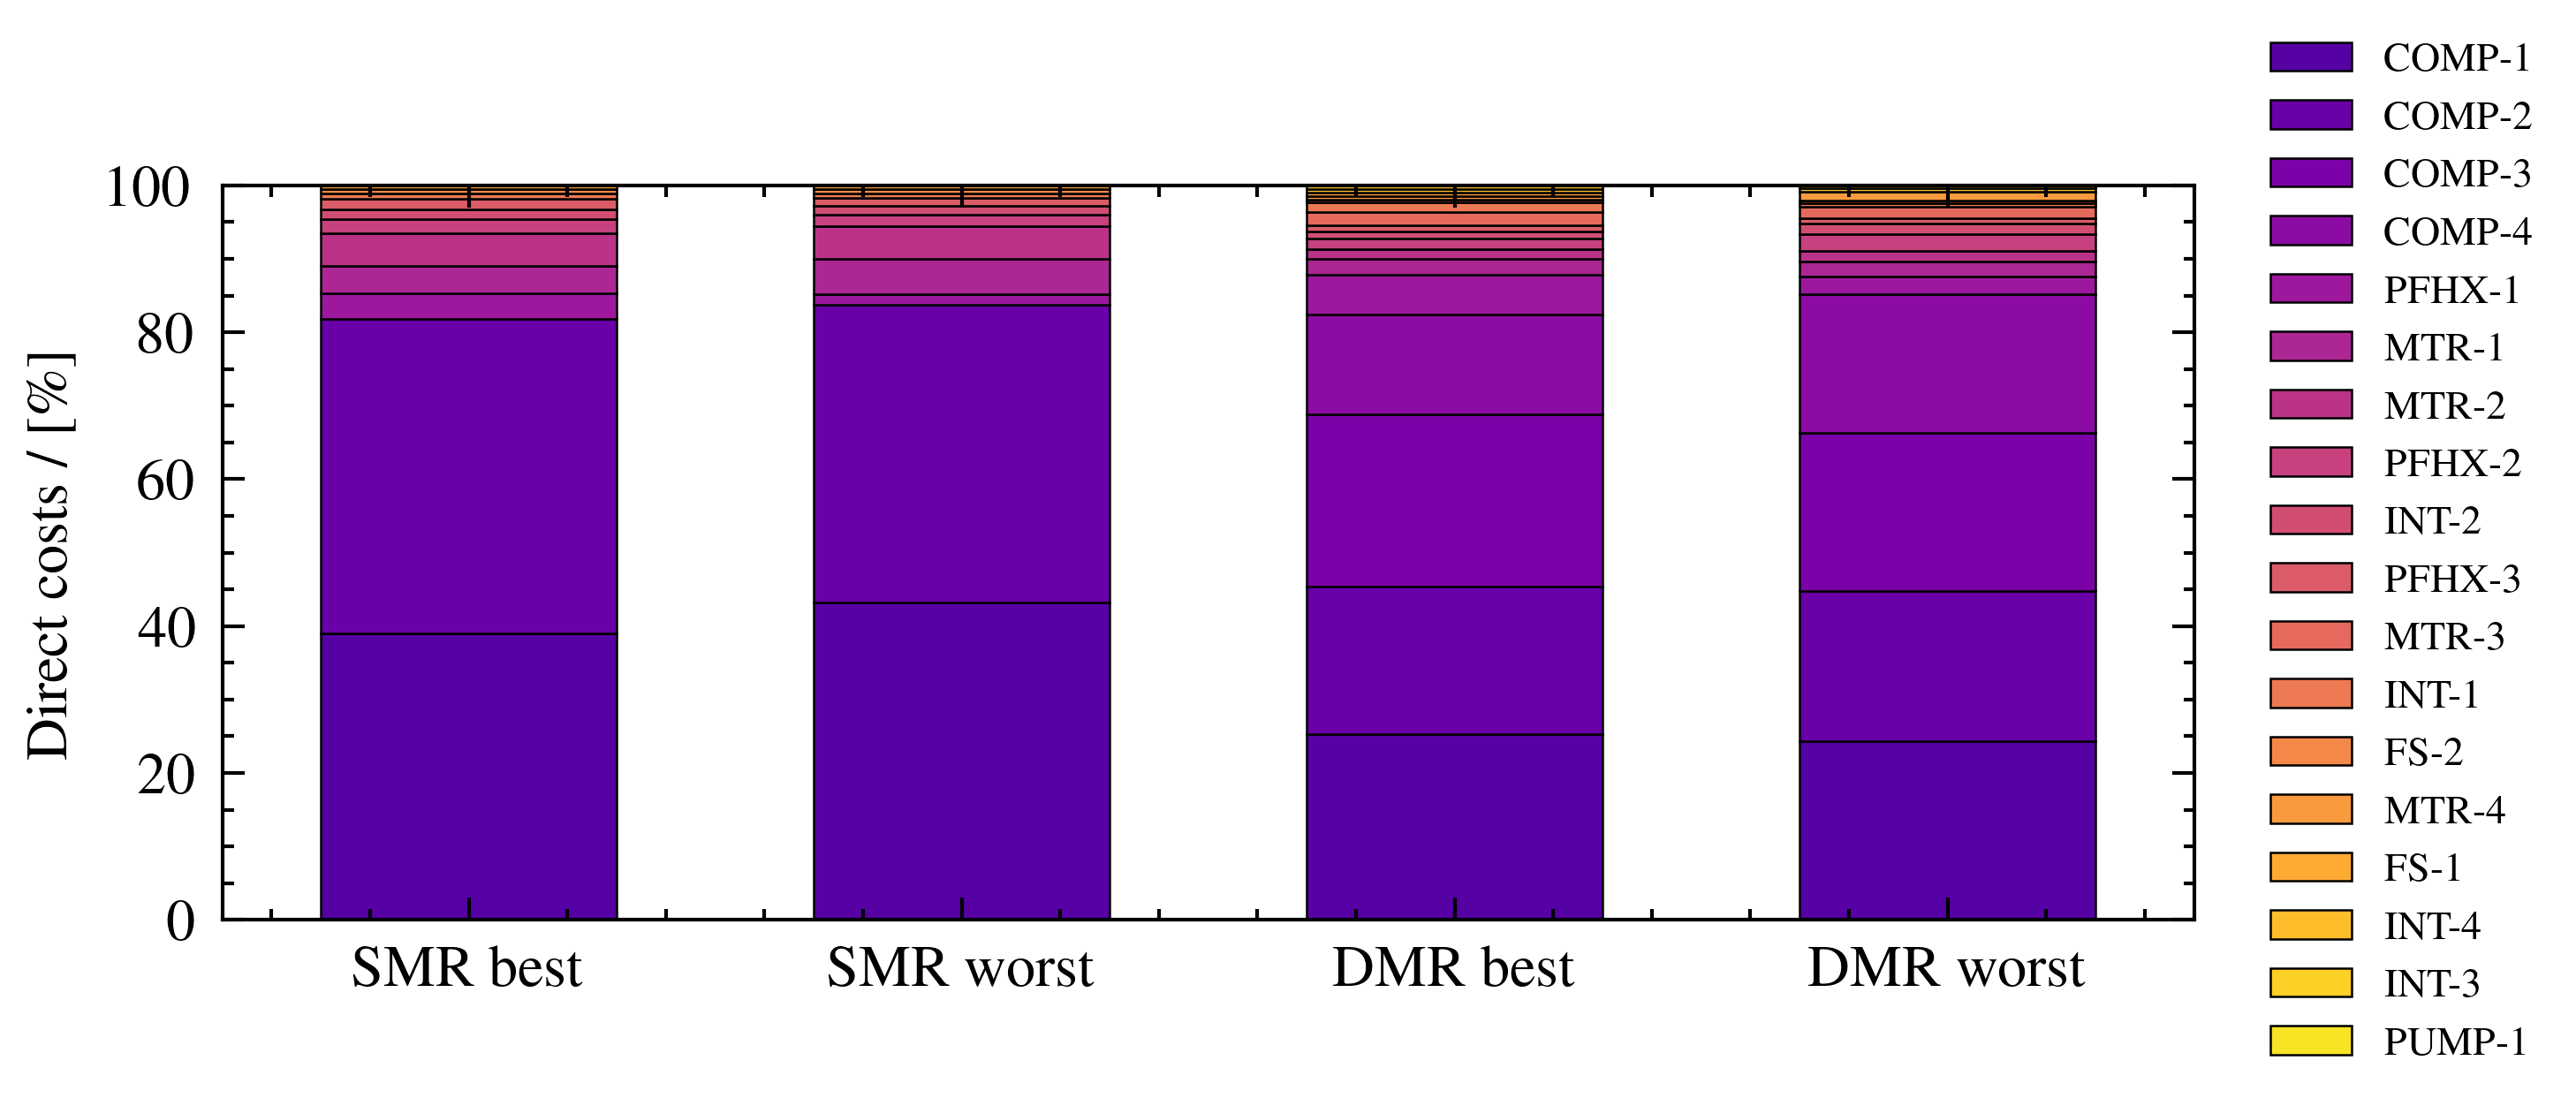

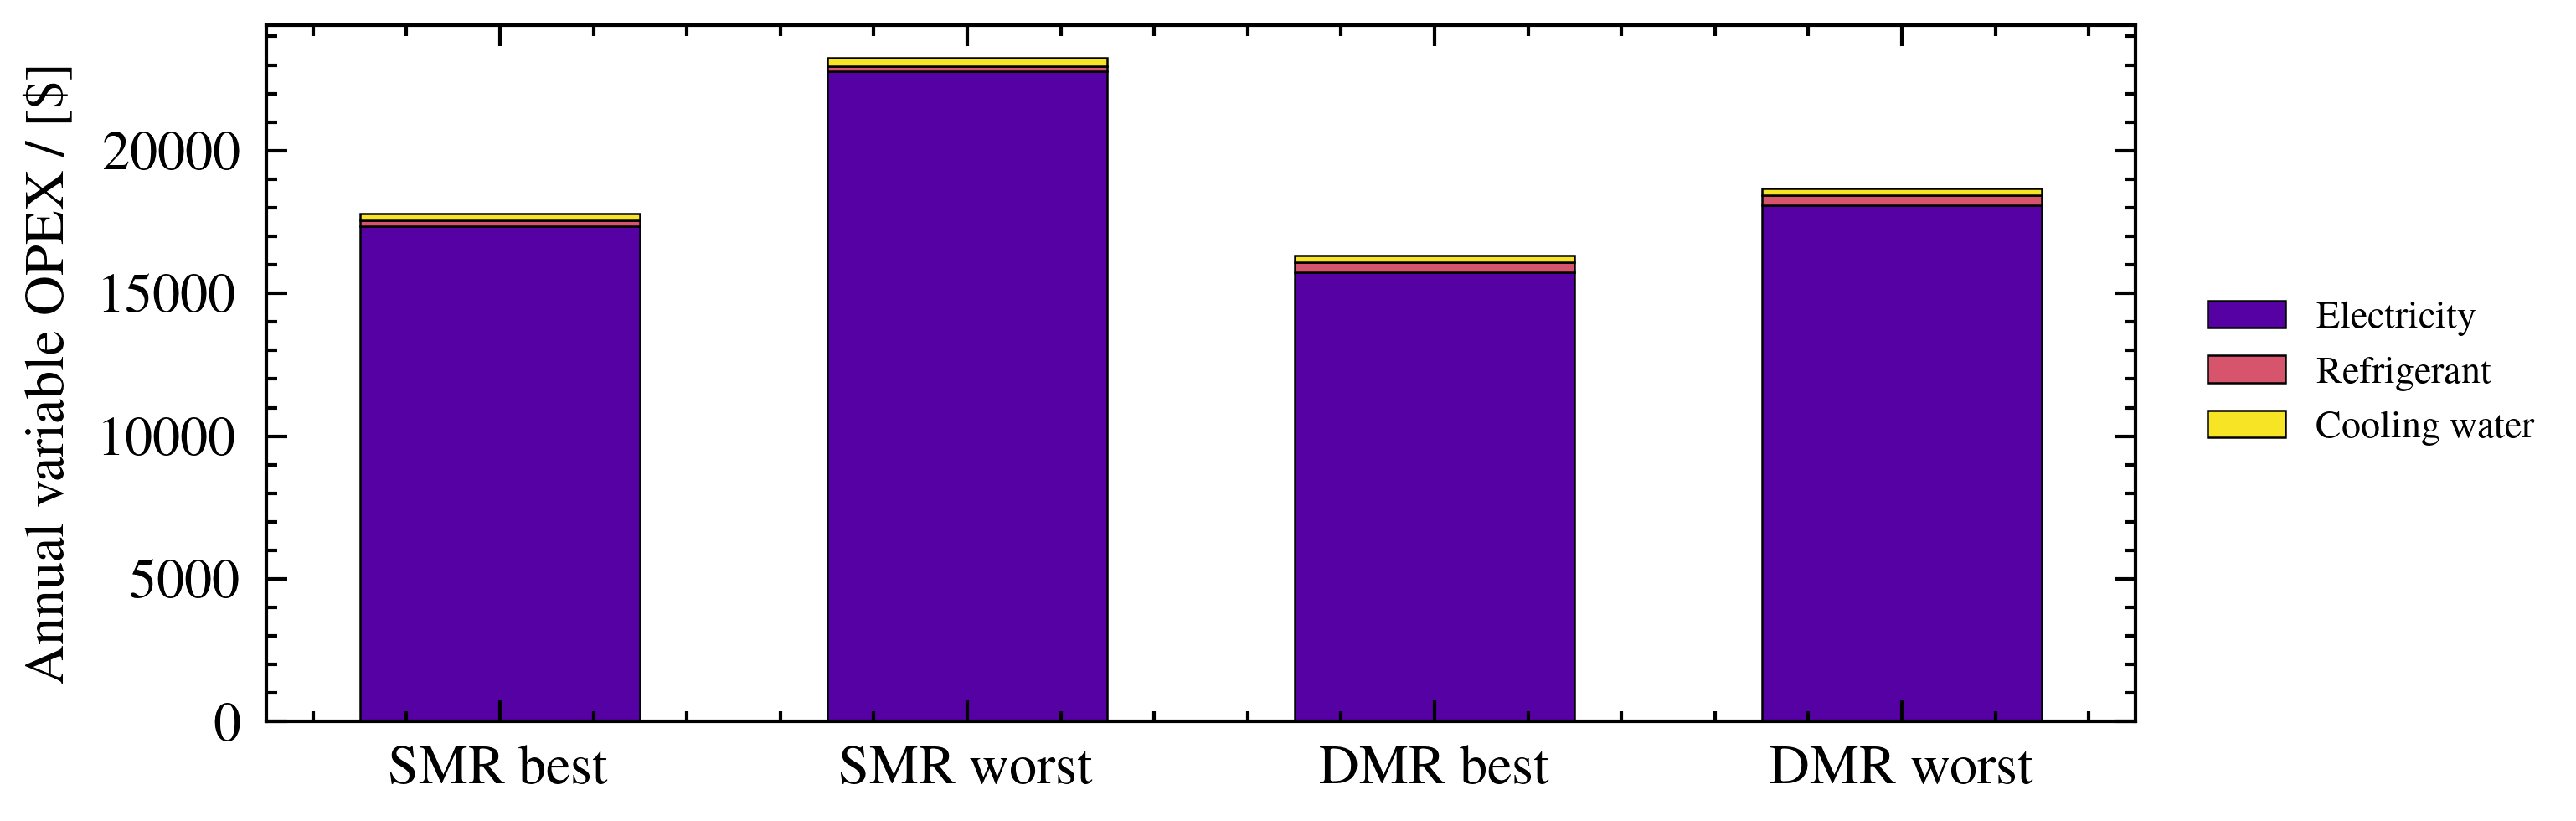

In [10]:
plot_direct_costs_bar(plants=[SMR_best, SMR_worst, DMR_best, DMR_worst], pct=True)  # We set pct=True to show direct cost components as percentages of total direct costs
plot_variable_opex_bar(plants=[SMR_best, SMR_worst, DMR_best, DMR_worst])  # We set pct=True to show variable OPEX components as percentages of total variable OPEX

#### **Step #7. Comparing the levelized cost and the specific energy consumption of SMR and DMR configurations**

<p style='text-align: justify;'>We now have the levelized cost and specific energy consumption for each precooling system configuration. These values can be plotted to allow for a clearer comparison.</p>

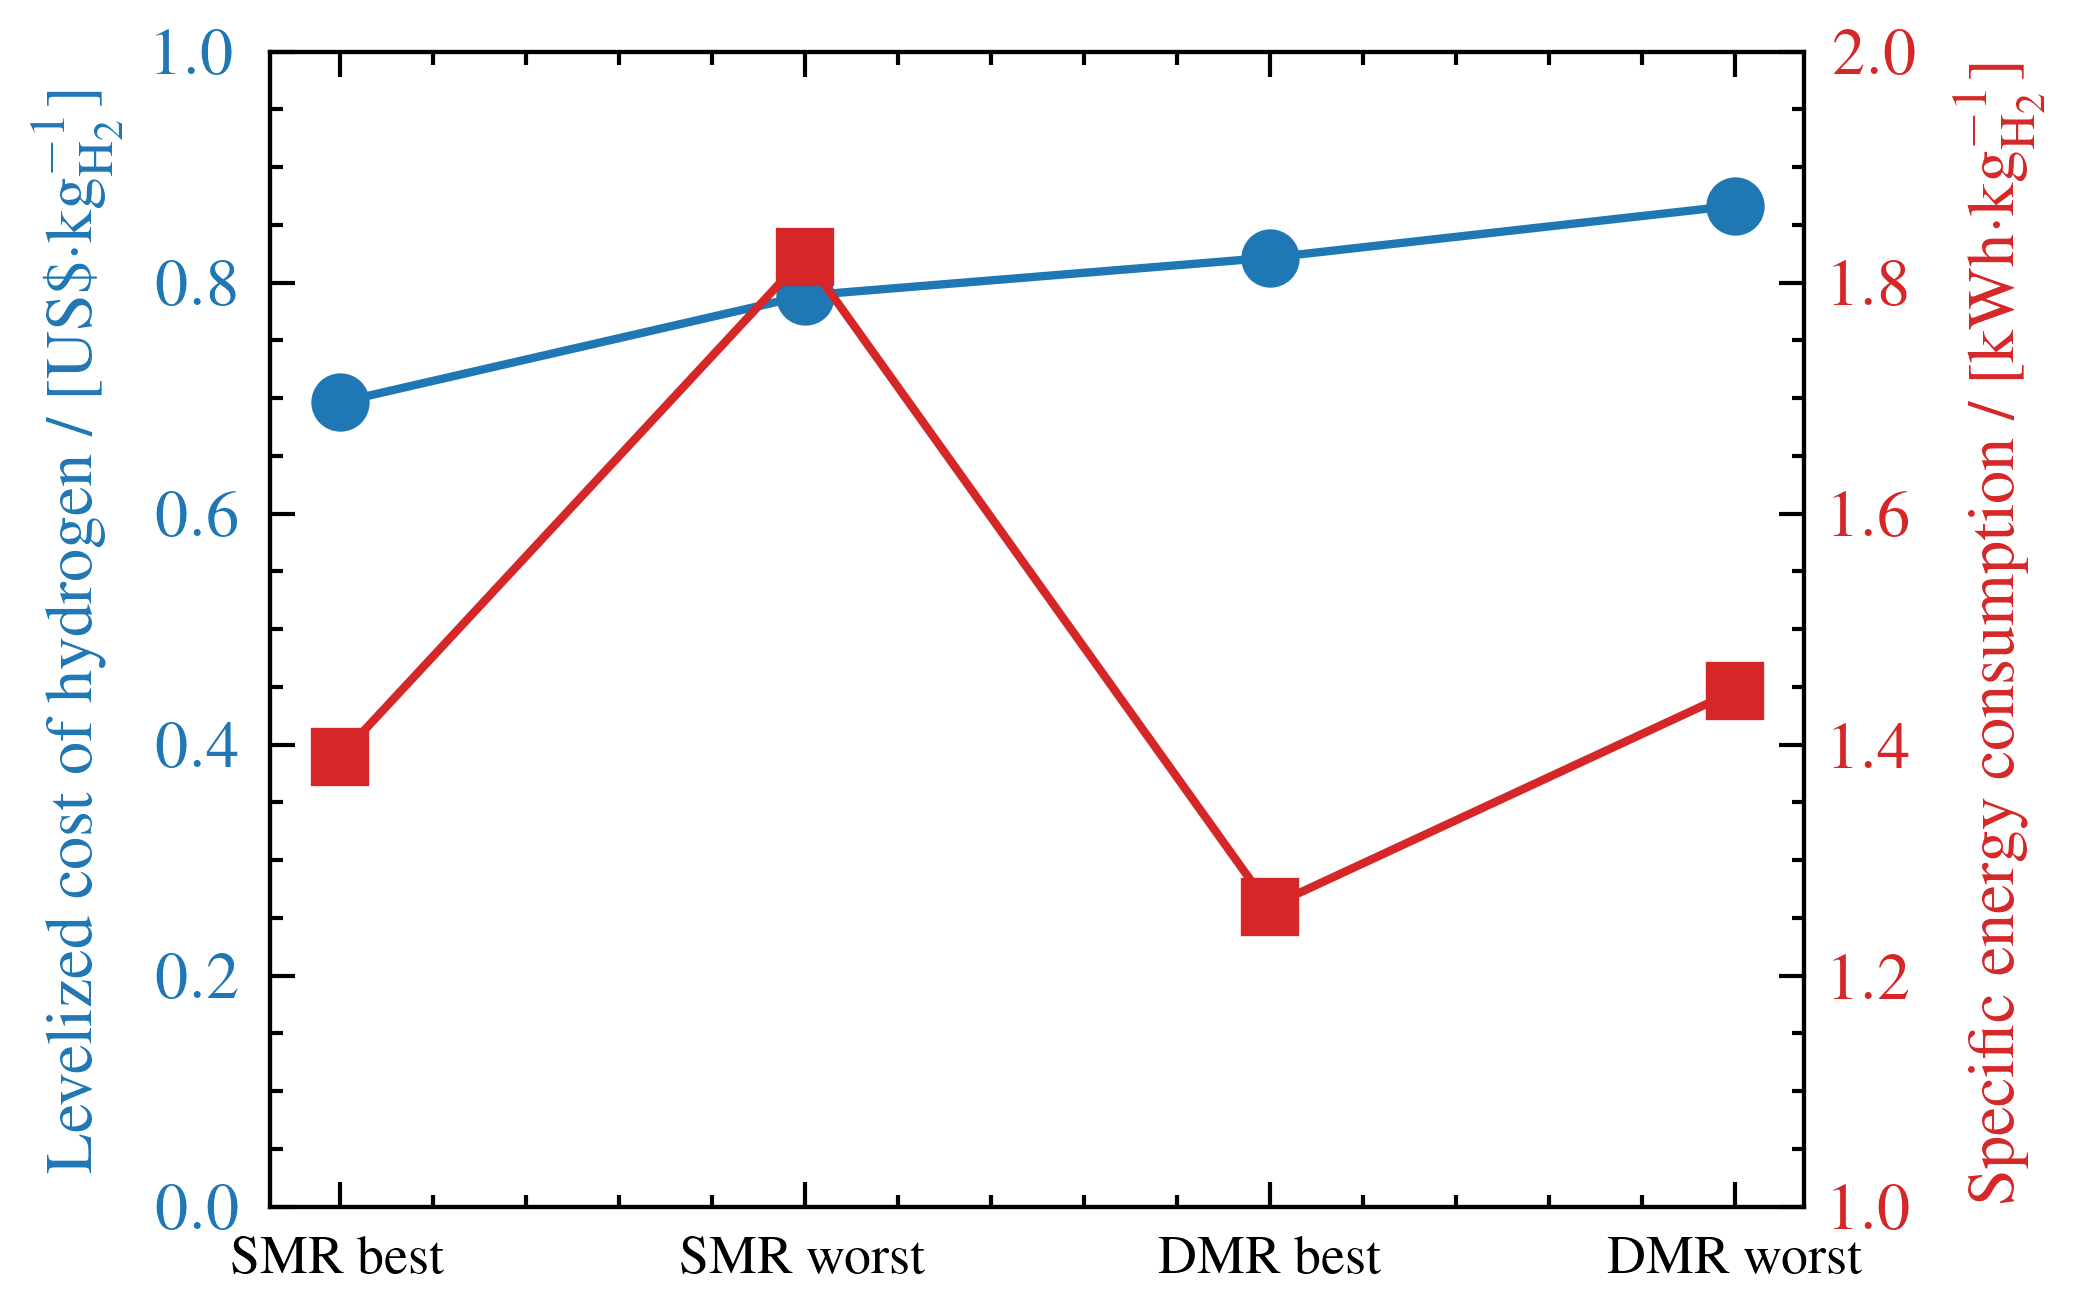

In [11]:
plants = [SMR_best, SMR_worst, DMR_best, DMR_worst]
names = [p.name for p in plants]
costs = [p.levelized_cost for p in plants]
secs = [SEC_SMR_best, SEC_SMR_worst, SEC_DMR_best, SEC_DMR_worst]

fig, ax1 = plt.subplots()

# First y-axis (levelized cost)
ax1.plot(names, costs, color="tab:blue", marker="o", label=r"Levelized cost of hydrogen / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]")
ax1.tick_params(axis="x", labelsize=6.5)
ax1.set_ylabel(r"Levelized cost of hydrogen / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0, 1)  # Set y-limit for better visibility

# Second y-axis (SEC)
ax2 = ax1.twinx()
ax2.plot(names, secs, color="tab:red", marker="s", label=r"Specific energy consumption / [kWh$\cdot$kg$^{-1}_\mathrm{H_2}$]")
ax2.set_ylabel(r"Specific energy consumption / [kWh$\cdot$kg$^{-1}_\mathrm{H_2}$]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_ylim(1, 2)  # Set y-limit for better visibility

plt.show()

<p style='text-align: justify;'>From the above plot, it can be concluded that the most energy-efficient systems do not necessarily correspond to the most cost-effective solutions. This is evident in the DMR best-case scenario, which exhibits the lowest specific energy consumption (SEC); however, its levelized cost is higher than both the SMR best- and worst-case scenarios. Conversely, the SMR worst-case scenario results in the highest SEC by a significant margin, yet it still demonstrates better cost performance than both the DMR best- and worst-case scenarios.</p>

<p style='text-align: justify;'>These findings highlight an important result: higher efficiency does not always translate into superior economic performance. In some cases, more efficient systems may incur higher overall costs and may even lead to increased complexity, rendering them technically impractical. This highlights the importance of conducting a techno-economic analysis when evaluating and comparing process alternatives.</p>

#### **Step #8. Run the Monte Carlo uncertainty analysis for all four cases**

We can now perform a Monte Carlo analysis for each configuration to evaluate the probability distribution of levelized costs under economic uncertainties.

In [12]:
monte_carlo(SMR_best, num_samples=1_000_000, batch_size=1000)
monte_carlo(SMR_worst, num_samples=1_000_000, batch_size=1000)
monte_carlo(DMR_best, num_samples=1_000_000, batch_size=1000)
monte_carlo(DMR_worst, num_samples=1_000_000, batch_size=1000)

Monte Carlo: 100%|██████████| 1000/1000 [03:07<00:00,  5.32it/s]


({'LCOP': array([0.78612659, 0.78612659, 0.78612659, ..., 0.79087062, 0.79087062,
         0.79087062], shape=(1000000,)),
  'ROI': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'NPV': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'PBT': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,))},
 {'Fixed capital factor': array([1.54418227, 0.97611579, 1.07555045, ..., 0.71607427, 0.59131987,
         0.95166443], shape=(1000000,)),
  'Fixed opex factor': array([0.86037438, 0.9136441 , 0.98800832, ..., 0.91802132, 1.04820199,
         0.48578381], shape=(1000000,)),
  'Operator hourly rate': array([44.76939555, 36.37671944, 39.35692076, ..., 28.28490886,
         43.41677703, 47.02082825], shape=(1000000,)),
  'Project lifetime': array([19.1830604 , 22.97113164, 14.65876269, ..., 24.97667392,
         27.80417783, 17.21119494], shape=(1000000,)),
  'Interest rate': array([0.09299579, 0.14264534, 0.1121178 , ..., 0.10997859, 0.12694024,
         0.09763137], shape=(

#### **Step #9. Use the `plot_multiple_monte_carlo` to plot the probability distribution for all four cases**

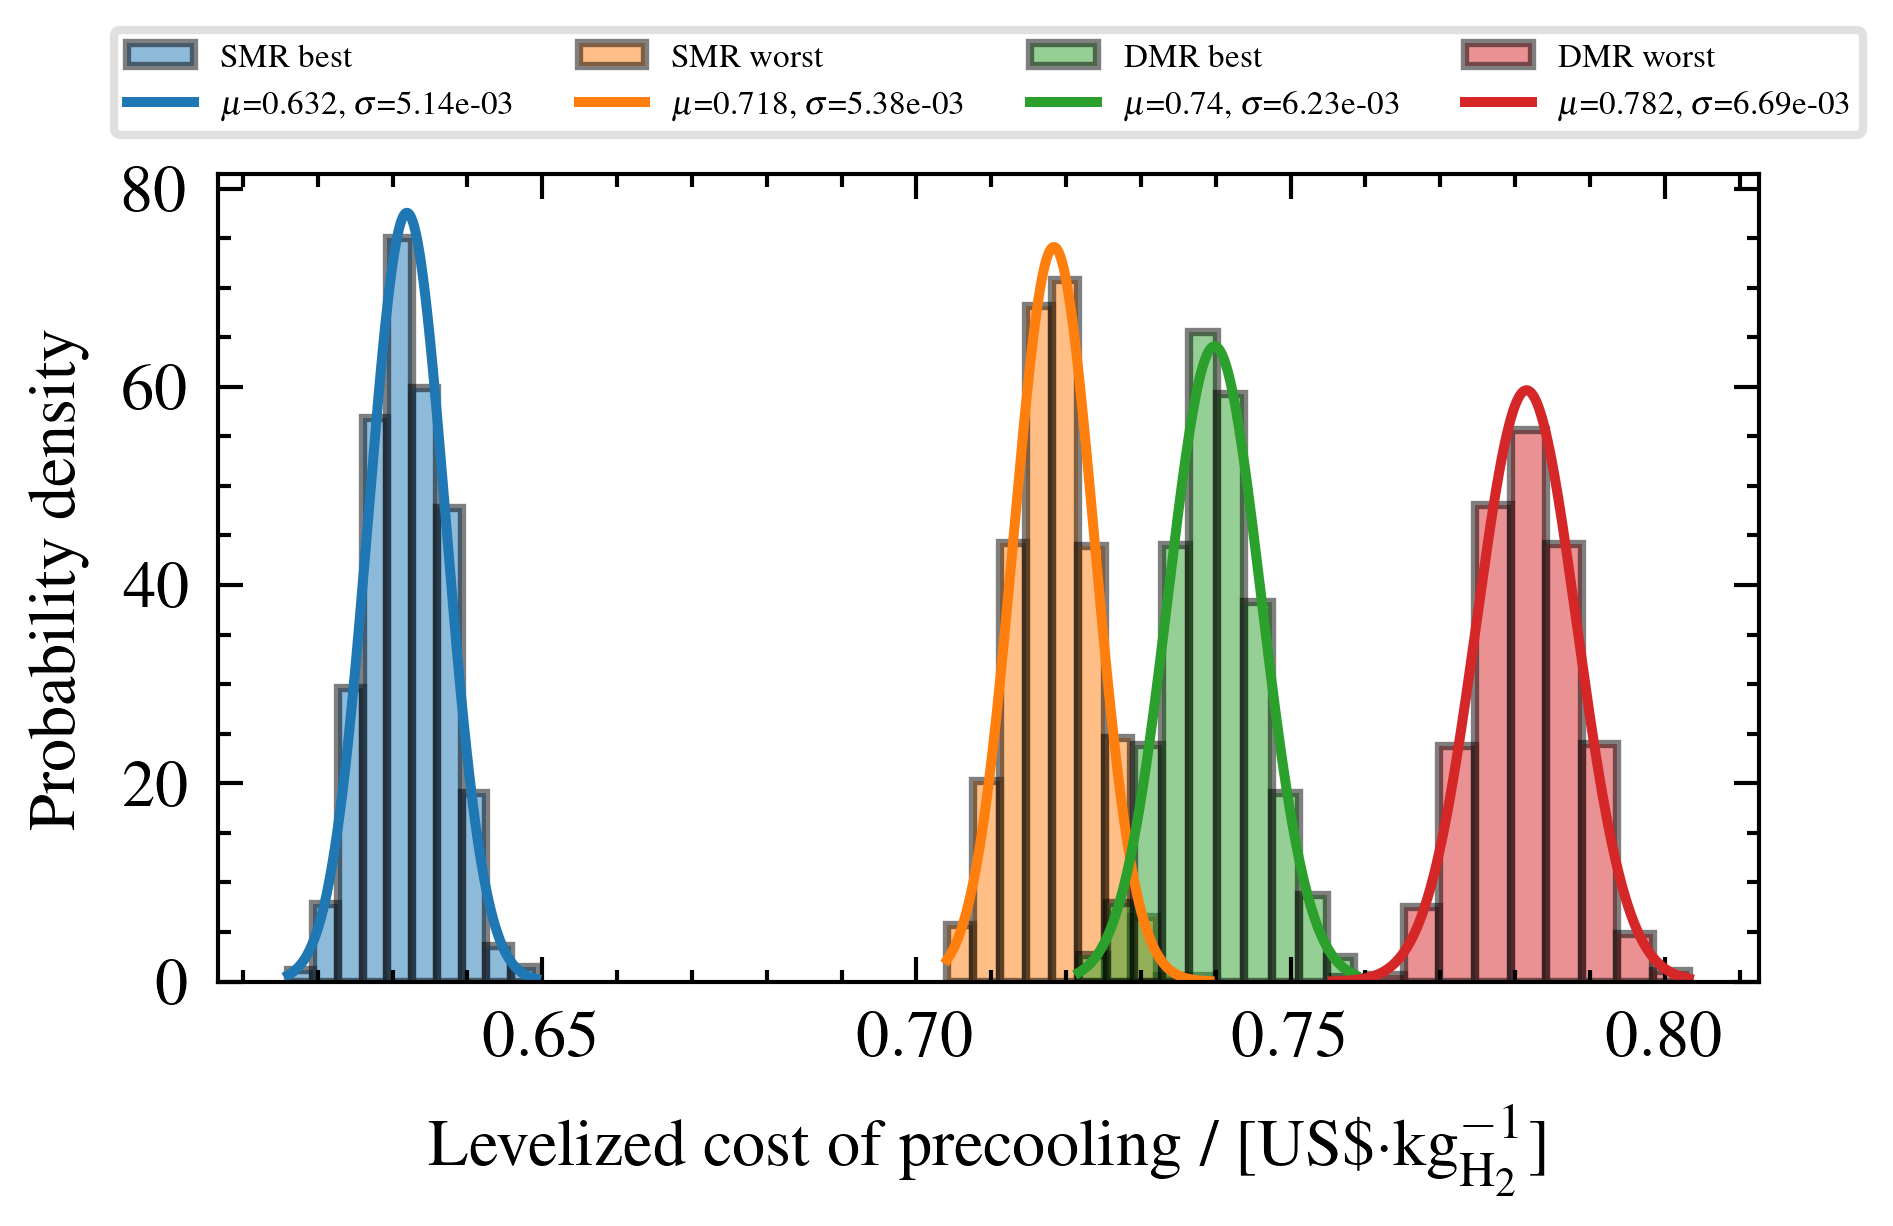

In [13]:
plot_multiple_monte_carlo([SMR_best, SMR_worst, DMR_best, DMR_worst], bins=10,
                          label=r'Levelized cost of precooling / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]')

<p style='text-align: justify;'>The above distributions clearly separate SMR best from all others, showing robust cost advantage. Meanwhile, SMR worst and DMR best overlap significantly, suggesting that uncertainties could make them practically indistinguishable in cost performance. DMR worst is consistently the least attractive option. This reinforces the earlier finding: energy efficiency (e.g., lower SEC in DMR) does not guarantee lower costs, and Monte Carlo analysis underlines that SMR (even in the worst case) remains economically more robust than DMR.</p>

## References

[1] Anwar, R. R. Multi-Objective Optimization of Precooling Stage in Hydrogen Liquefaction. Master thesis, Delft University of Technology, 2025. https://repository.tudelft.nl/record/uuid:a4232495-74a5-4fd4-a275-ce19fa930077 (accessed 2025-12-02).